In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

import os
import sys
import logging

In [2]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/multiome_rna_imputed_gene_subset.h5ad"

In [3]:
!rsync -aP $adata_infile /dev/shm/

sending incremental file list
multiome_rna_magic_imputed.h5ad
  1,578,553,708 100%  401.97MB/s    0:00:03 (xfr#1, to-chk=0/1)


# Filter cells for placing on trajectory

In [4]:
#load the anndata 
adata=sc.read_h5ad(adata_infile)
adata


AnnData object with n_obs × n_vars = 32418 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'DM_EigenValues', 'cell_type_major_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sub_cell_type_colors', 'topic_dendogram', 'umap'
    obsm: 'DM_EigenVectors', 'X_joint_umap_features',

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


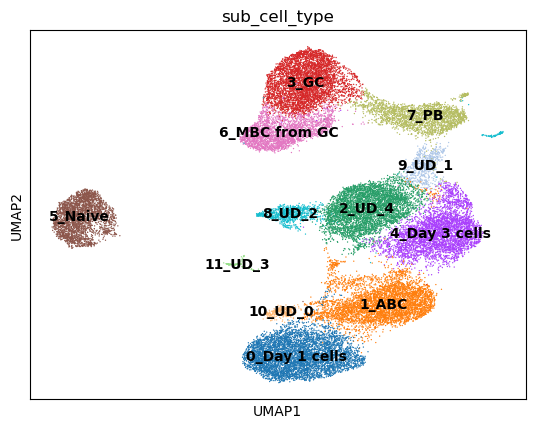

In [5]:
sc.pl.umap(adata,color=['sub_cell_type'],legend_loc='on data')

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


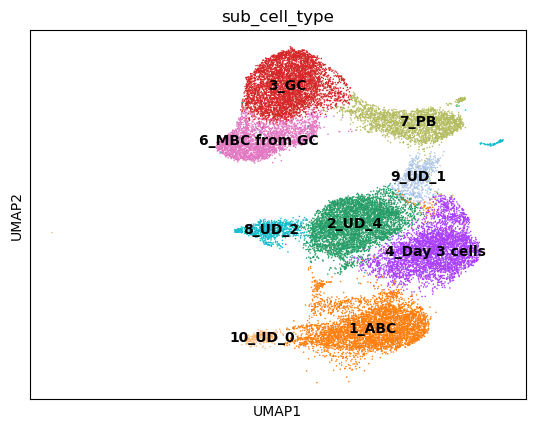

In [6]:
# subset the anndata to only include the cells that are in the sub_cell_type categories of interest
adata=adata[adata.obs['sub_cell_type'].isin(['10_UD_0','1_ABC','4_Day 3 cells','8_UD_2','2_UD_4','3_GC','6_MBC from GC','9_UD_1','7_PB'])]
sc.pl.umap(adata,color=['sub_cell_type'],legend_loc='on data')


In [9]:
# save the anndata
adata.write('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_input_filtered_cells.h5ad')

# Run stream dim reduction on the anndata, with imputed gene expression and filtered cells

In [1]:
!rsync -aP /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_input_filtered_cells.h5ad /dev/shm/


sending incremental file list
stream_input_filtered_cells_v4.h5ad
  1,262,610,884 100%  442.52MB/s    0:00:02 (xfr#1, to-chk=0/1)


In [2]:
import stream as st
#read the stream result file pkl
adata=st.read(file_name='/dev/shm/stream_input_filtered_cells.h5ad', workdir='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs')

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs


In [3]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

#### Can select top variable genes for dimension reduction, or run on all highly_variable imputed genes (3k)

Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
152 variable genes are selected


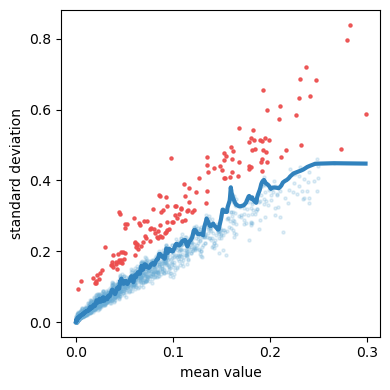

In [4]:
import stream as st
st.set_workdir(adata,'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs')
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

In [5]:
adata

AnnData object with n_obs × n_vars = 24210 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'DM_EigenValues', 'cell_type_major_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sub_cell_type_colors', 'topic_dendogram', 'umap', 'workdir', 'var_genes'
    obsm: 'DM_EigenVectors', 

In [6]:
adata.uns['var_genes'] #use all genes for dimension reduction, anot just the top 152 var genes from the previous step

Index(['TNFRSF9', 'GADD45A', 'COL24A1', 'IL6R', 'CD247', 'ASPM', 'MARK1',
       'KIF26B', 'ERLEC1', 'EML6',
       ...
       'ZBP1', 'LIME1', 'IGLV10-54', 'IGLC2', 'IGLC3', 'DERL3', 'TPST2',
       'MIAT', 'XBP1', 'FAAH2'],
      dtype='object', length=152)

In [13]:
st.dimension_reduction(adata,method='se',feature='all',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature all is being used ...
64 cpus are being used ...


#### Order cell types based on how you think the pseudotime should be

In [14]:
import pandas as pd
adata.obs['sub_cell_type'] = pd.Categorical(
    adata.obs['sub_cell_type'],
    categories=['10_UD_0','1_ABC','4_Day 3 cells','8_UD_2','2_UD_4','3_GC','6_MBC from GC','9_UD_1','7_PB'],
    ordered=True
)

In [15]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: DM_EigenVectors, X_joint_umap_features, X_pca, X_topic_compositions, X_umap, X_umap_features, var_genes, X_se, X_dr)


In [16]:
print(adata.uns['sub_cell_type_colors'])

['#ff7f0e' '#279e68' '#d62728' '#aa40fc' '#e377c2' '#b5bd61' '#17becf'
 '#aec7e8' '#ffbb78']


In [17]:
# Create a custom dictionary mapping sub_cell_types to colors
# color_dict = {
#     '1_ABC': '#FF7F00',    # Orange
#     '2_UD_4': '#006400',   # Dark green
#     '3_GC': '#D62728',     # Red
#     '4_Day 3 cells': '#9467BD',  # Purple
#     '6_MBC from GC': '#E377C2',  # Pink
#     '7_PB': '#808000',     # Olive Green
#     '8_UD_2': '#17BECF',   # Cyan
#     '9_UD_1': '#87CEEB',   # Sky Blue
#     '10_UD_0': '#FFE4B5',  # Very Light Orange
#     '11_UD_3': '#D3D3D3'   # Light Gray
# }
# Create the color dict from the uns storing the colors for the ordered sub_cell_types which are a pd.Categorical object with the ordered categories being the keys and the colors being the values
color_dict = dict(zip(adata.obs['sub_cell_type'].cat.categories, adata.uns['sub_cell_type_colors']))
# Add a new column to obs with the color for each cell
adata.obs['sub_cell_type_colors'] = adata.obs['sub_cell_type'].map(color_dict)

# Verify the new column
print(adata.obs[['sub_cell_type', 'sub_cell_type_colors']].head())

                   sub_cell_type sub_cell_type_colors
AAACAGCCAAGCCACT-3          3_GC              #b5bd61
AAACAGCCAAGGTGCA-1         1_ABC              #279e68
AAACAGCCAATTATGC-2        8_UD_2              #aa40fc
AAACAGCCATTCAGCA-3          3_GC              #b5bd61
AAACATGCAAAGCTCC-1         1_ABC              #279e68


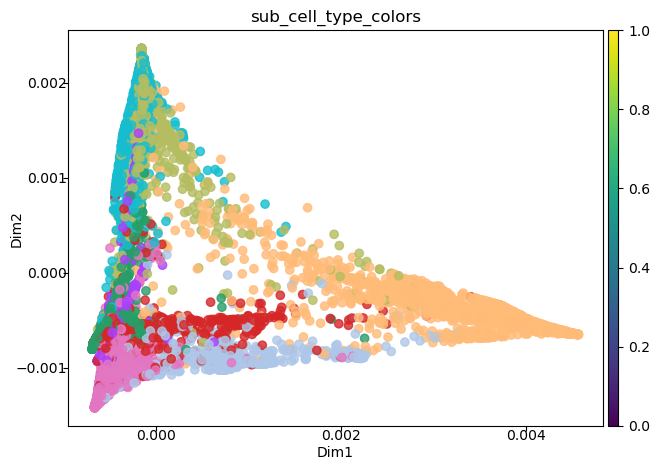

In [18]:
st.plot_dimension_reduction(adata,color=['sub_cell_type_colors'],n_components=2)

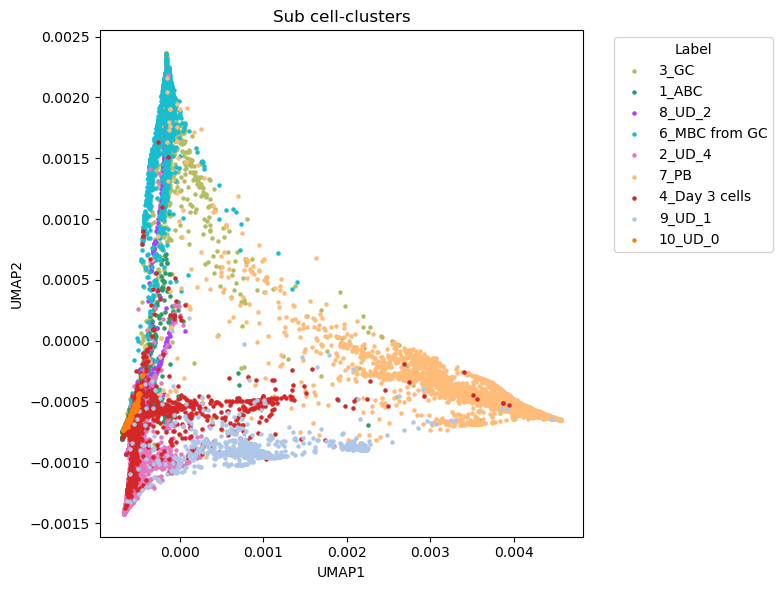

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['sub_cell_type']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Trajectory inference by fitting elastic graph

In [20]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmpwb704ptu
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 24210 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
4.524e-08
	
50
	
49
	
46
	
1
	
0
	
0
	
1.599e-08
	
1.466e-08
	
0.9944
	
0.9949
	
2.732e-08
	
1.931e-09
	
9.655e-08
	
4.827e-06
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


56.843 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


In [21]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the day-1 to activated to undefined cell branch

Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 83 nodes on 24210 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 
80
 
81
 
82
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||83
	
3.148e-08
	
83
	
82
	
79
	
1
	
0
	
0
	
1.286e-08
	
1.21e-08
	
0.9955
	
0.9957
	
1.77e-08
	
9.177e-10
	
7.617e-08
	
6.322e-06
	
0


8.187 sec elapsed

Number of branches after optimizing branching: 3


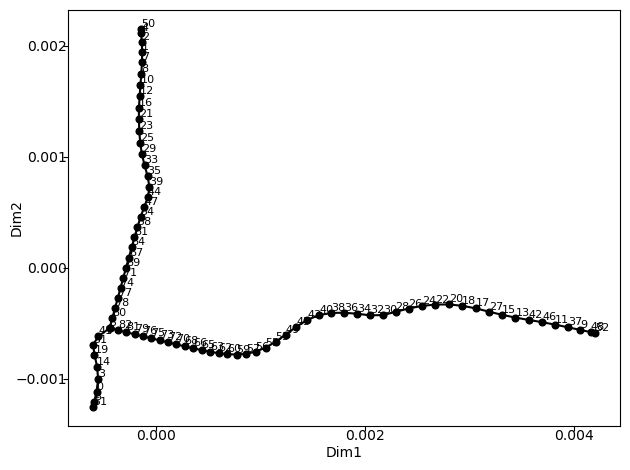

In [22]:
st.plot_branches(adata,show_text=True)

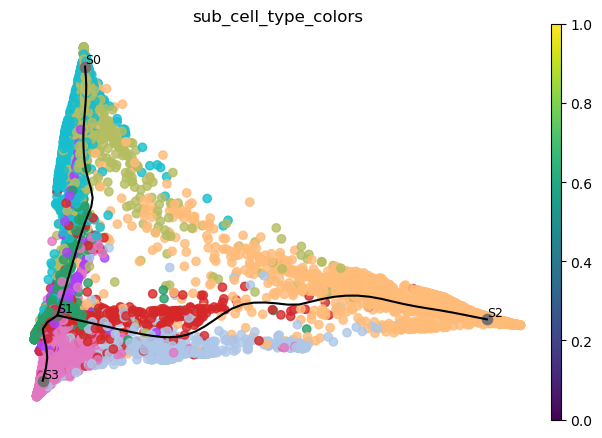

In [23]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['sub_cell_type_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


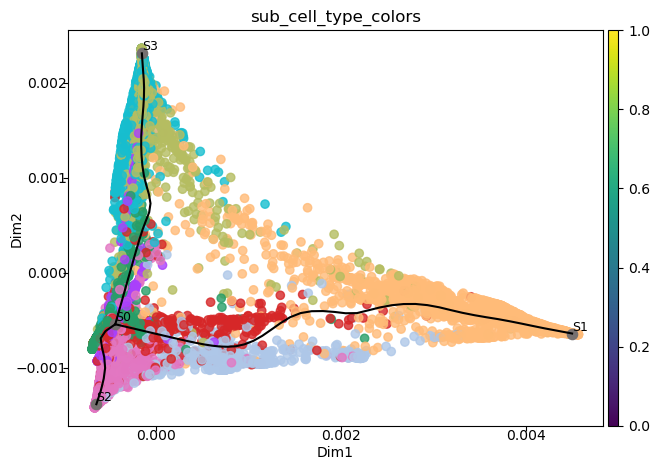

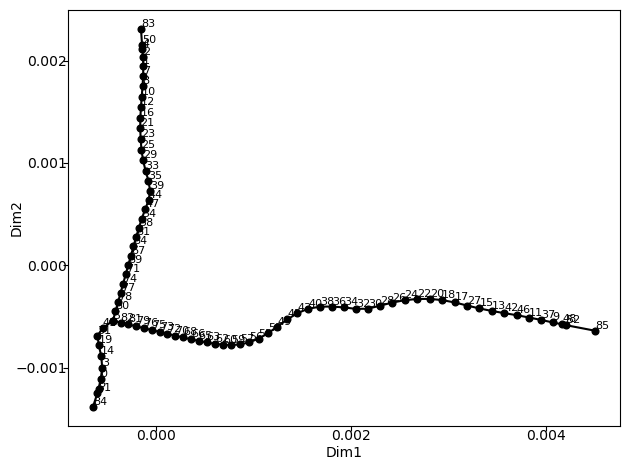

In [24]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['sub_cell_type_colors'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

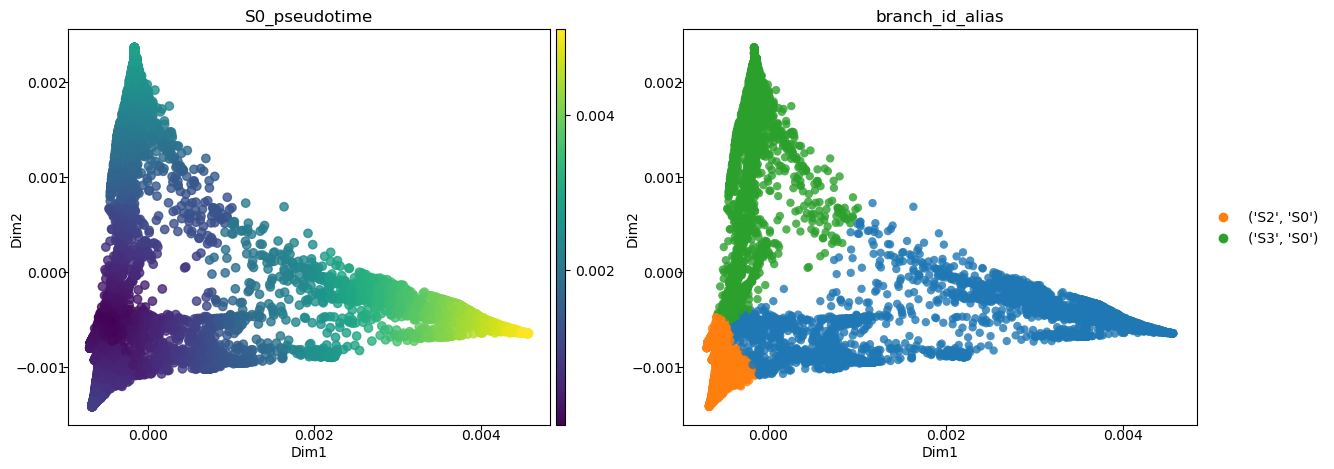

In [47]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S0_pseudotime','branch_id_alias'])


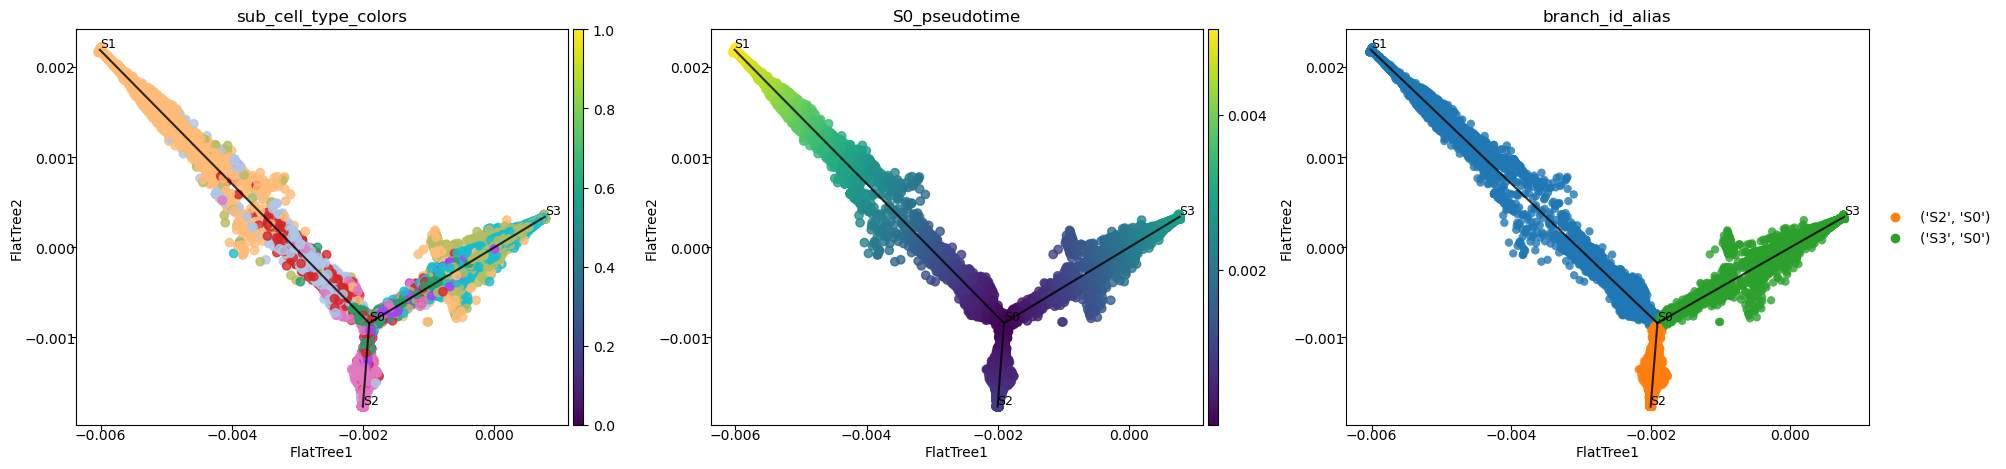

In [26]:
st.plot_flat_tree(adata,color=['sub_cell_type_colors','S0_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)

### Verifying pseudotime with real time in days

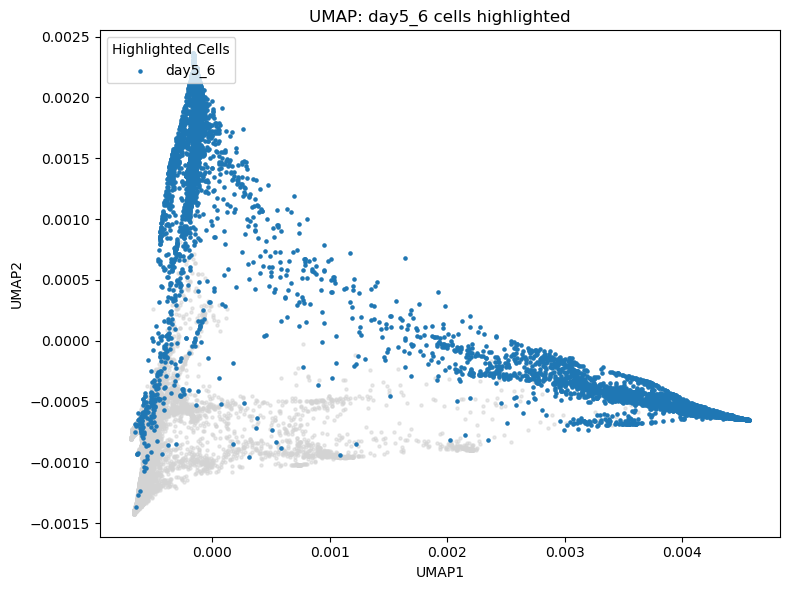

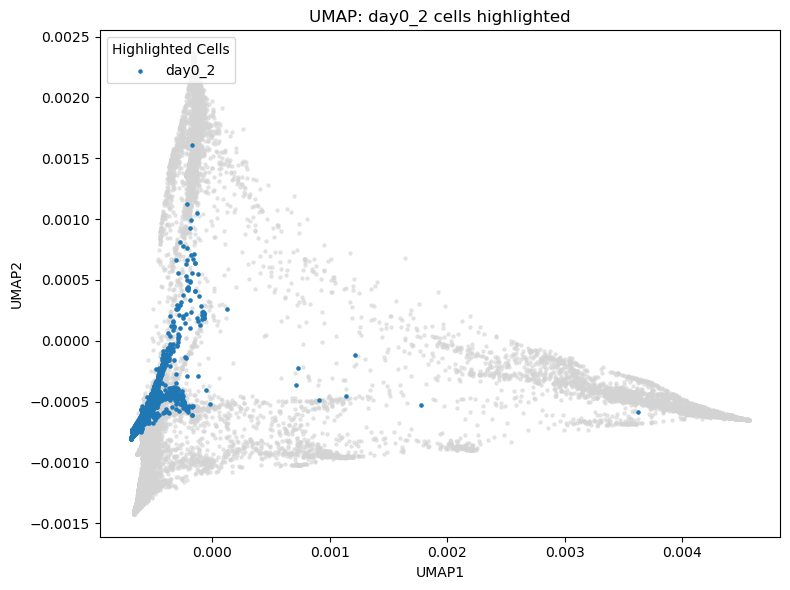

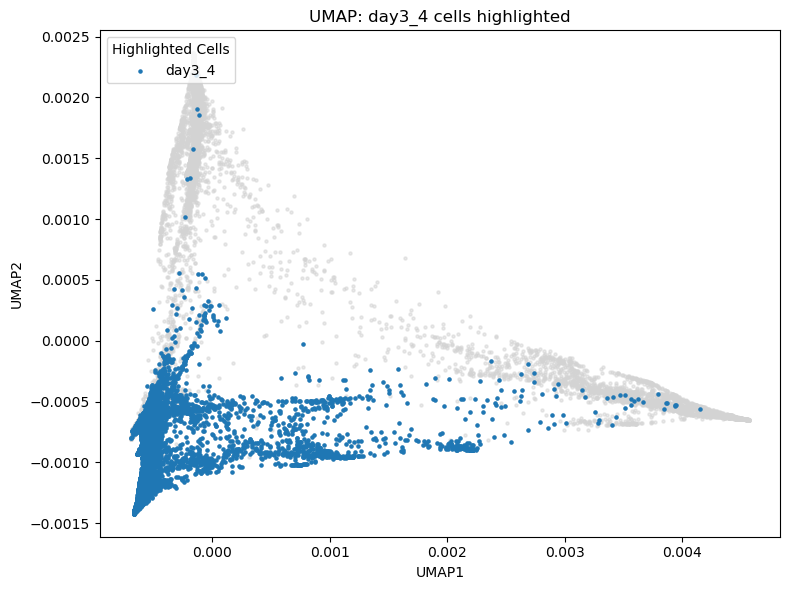

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['cell_type_major']

# Get unique labels
unique_labels = labels.unique()

# Define a color for the highlighted cells and for the background cells
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create a plot for each unique label
for label in unique_labels:
    plt.figure(figsize=(8, 6))
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

    plt.title(f'UMAP: {label} cells highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')
    plt.tight_layout()
    plt.show()

### Verifying genes of interest's expression per branch on the trajectory

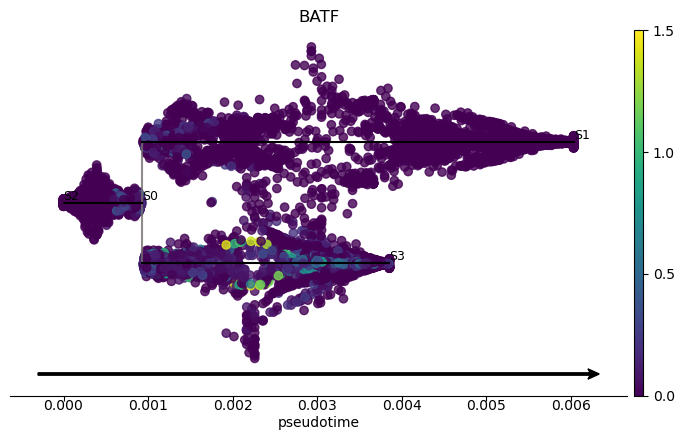

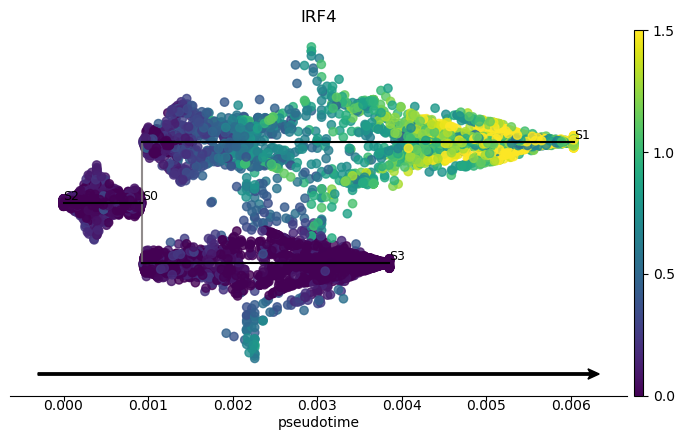

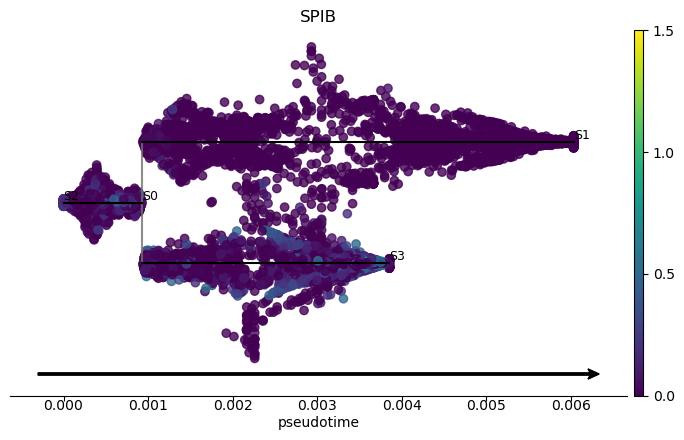

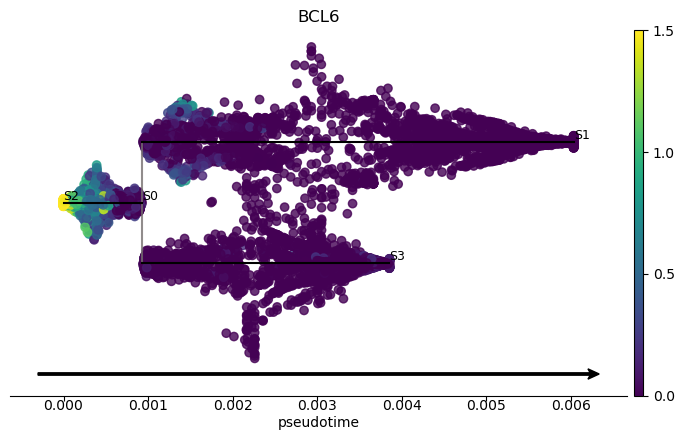

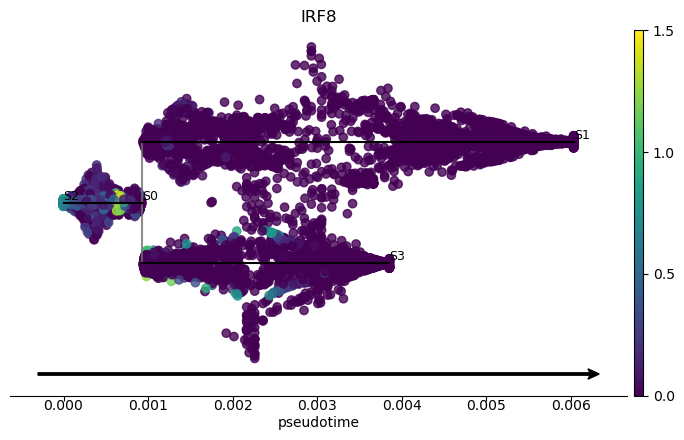

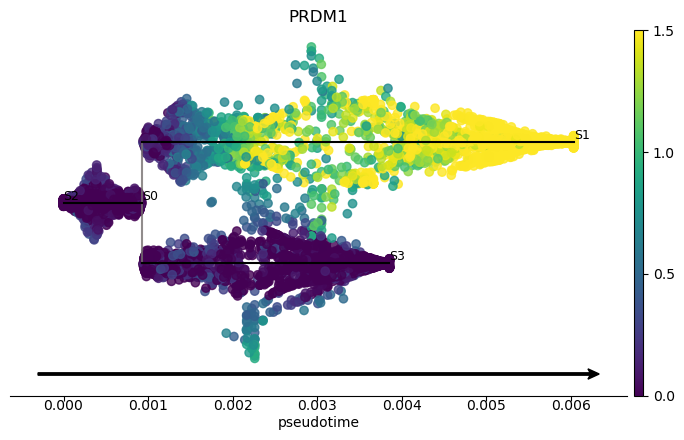

In [38]:
st.plot_stream_sc(adata,root='S2',color=['BATF','IRF4', 'SPIB', 'BCL6', 'IRF8', 'PRDM1'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [37]:
adata.obs.head()

,cell_type_major,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,topic_0,topic_1,topic_2,topic_3,...,kmeans,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S2_pseudotime,S1_pseudotime
AAACAGCCAAGCCACT-3,day5_6,3582,3580,8281.0,846.0,10.216157,0.018575,0.013160,0.008065,0.036125,...,cluster 8,83,"(83, 5)","(S3, S0)",0.000058,0.000005,0.002865,0.000058,0.003796,0.007966
AAACAGCCAAGGTGCA-1,day0_2,2416,2415,4951.0,471.0,9.513230,0.038631,0.025551,0.318661,0.011544,...,cluster 4,31,"(84, 5)","(S2, S0)",0.000723,0.000038,0.000208,0.003130,0.000723,0.005310
AAACAGCCAATTATGC-2,day3_4,2196,2196,5658.0,378.0,6.680806,0.025713,0.012913,0.009968,0.041186,...,cluster 4,41,"(84, 5)","(S2, S0)",0.000823,0.000049,0.000108,0.003031,0.000823,0.005210
AAACAGCCATTCAGCA-3,day5_6,4483,4477,11874.0,917.0,7.722755,0.017965,0.018262,0.013738,0.013966,...,cluster 8,1,"(83, 5)","(S3, S0)",0.000360,0.000005,0.002562,0.000360,0.003493,0.007664
AAACATGCAAAGCTCC-1,day0_2,2903,2903,6320.0,532.0,8.417722,0.018026,0.011716,0.045281,0.014255,...,cluster 4,31,"(84, 5)","(S2, S0)",0.000709,0.000049,0.000222,0.003144,0.000709,0.005324


In [32]:
# write stream result to pkl
st.write(adata,file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/all_cells_from_day2_traj/stream_result_all_cells.pkl')


In [33]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/all_cells_from_day2_traj'
# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')

#### Make subsets of the sub cell types

In [40]:
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/all_cells_from_day2/data'
adata.obs.sub_cell_type.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [41]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 24210 × 0
    obs: 0
    obsm: 'X_dr'

In [42]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

                  NaN         x         y
0  AAACAGCCAAGCCACT-3 -0.000159  0.002252
1  AAACAGCCAAGGTGCA-1 -0.000629 -0.000659
2  AAACAGCCAATTATGC-2 -0.000563 -0.000564
3  AAACAGCCATTCAGCA-3 -0.000139  0.001950
4  AAACATGCAAAGCTCC-1 -0.000652 -0.000700


In [43]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])